# 1. Import and Install Dependencies

In [ ]:
# !pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

In [ ]:
# !pip install --upgrade mediapipe

In [1]:
import cv2
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

2024-11-07 11:53:18.629023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730960599.463564    4134 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730960599.681615    4134 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 11:53:21.381507: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Keypoints using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [6]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

# 4. Setup Folders for Collection

In [7]:
# # Path for exported data, numpy arrays
DATA_PATH = os.path.join('/home/eric/Desktop/ML/Minor/data/ISL/') 
# # Actions that we try to detect
actions = np.array(['a','b','c','d','e','f','g', 'h', 'i','j','k','l','m','n','o','p','q','r','s','t','u', 'v', 'w','x','y','z'])

# # Thirty videos worth of data
no_sequences = 30

# # Videos are going to be 30 frames in length
sequence_length = 30

# # Folder start
start_folder = 30

# 6. Preprocess Data and Create Labels and Features

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [9]:
label_map = {label:num for num, label in enumerate(actions)}

In [10]:
label_map

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25}

In [11]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [12]:
np.array(sequences).shape

(780, 30, 126)

In [13]:
np.array(labels).shape

(780,)

In [14]:
X = np.array(sequences)

In [15]:
X.shape

(780, 30, 126)

In [16]:
y = to_categorical(labels).astype(int)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.08)

In [18]:
y_test.shape

(63, 26)

# 7. Build and Train LSTM Neural Network

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 126)))
model.add(Dropout(0.2))  # Light dropout after the first LSTM layer
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))  # Light dropout after the second LSTM layer
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Moderate dropout before the final dense layers
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))


/home/eric/miniconda3/envs/ML/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [41]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 30, 64)         │        48,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,218 (797.73 KB)

 Trainable params: 204,218 (797.73 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, recall_score,confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback,EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy',        
    patience=10,                
    restore_best_weights=True,  
    verbose=1                  
)
class MetricsHistory(Callback):
    def on_train_begin(self, logs=None):
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.train_accuracies.append(logs.get('accuracy'))
        self.val_accuracies.append(logs.get('val_accuracy'))

In [43]:
metrics_history = MetricsHistory()

In [44]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),  # Use 10% of data for validation
    epochs=50,  # Adjust based on performance
    batch_size=32,  # Set batch size based on data size and memory
    callbacks=[metrics_history,early_stopping]
)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 0.0411 - loss: 3.2480 - val_accuracy: 0.0635 - val_loss: 3.0875
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0591 - loss: 3.1074 - val_accuracy: 0.0476 - val_loss: 3.2098
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0628 - loss: 3.1448 - val_accuracy: 0.0952 - val_loss: 3.0552
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0948 - loss: 3.0431 - val_accuracy: 0.0794 - val_loss: 2.8761
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1014 - loss: 2.8761 - val_accuracy: 0.1429 - val_loss: 2.6426
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1328 - loss: 2.7280 - val_accuracy: 0.1905 - val_loss: 2.8288
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1397 - loss: 2.8317 - val_accuracy: 0.1905 - val_loss: 2.6284
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1559 - loss: 2.5556 - val_accuracy: 0.2698 - val_los

In [36]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred, class_names):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Display values for each element in the matrix
    print("Confusion Matrix:")
    print(cm)
    
    # Create a DataFrame for the confusion matrix
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix as a heatmap
    sn.set(font_scale=1.2)  # Label size
    plt.figure(figsize=(8, 6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})  # Font size for annotations
    plt.ylabel("Actual Label", size=15)
    plt.xlabel("Predicted Label", size=15)
    plt.title("Confusion Matrix", size=18)
    plt.show()
    
    
    # Calculate and print accuracy
    accuracy = (np.trace(cm) / np.sum(cm)) * 100
    print(f"Calculated Accuracy: {accuracy:.2f}%")
    return accuracy

def plot_loss(train_loss_avg,test_loss_avg,num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  print(num_epochs)
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training loss')
  plt.plot(epochs, loss_val, 'b', label='validation loss')
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()
def plot_accuracy(train_accuracy,test_accuracy,num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1,num_epochs+1)
  plt.plot(epochs, loss_train, 'g', label='Training accuracy')
  plt.plot(epochs, loss_val, 'b', label='validation accuracy')
  plt.title('Training and Validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

49


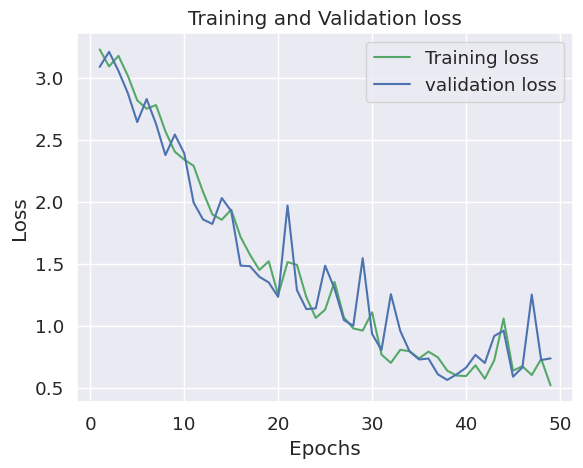

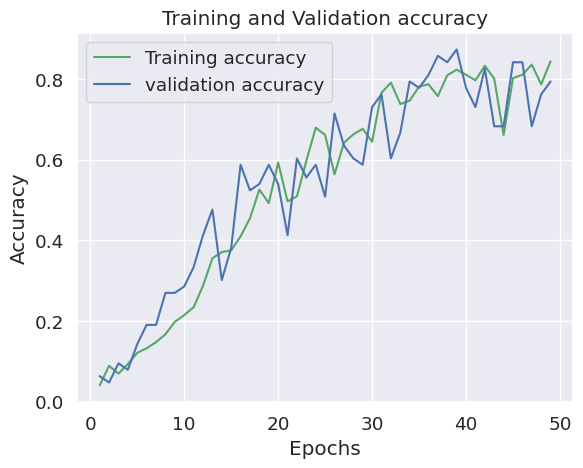

In [45]:
plot_loss(history.history['loss'], history.history['val_loss'], num_epochs=49)
plot_accuracy(history.history['accuracy'], history.history['val_accuracy'], num_epochs=49)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
[[4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 

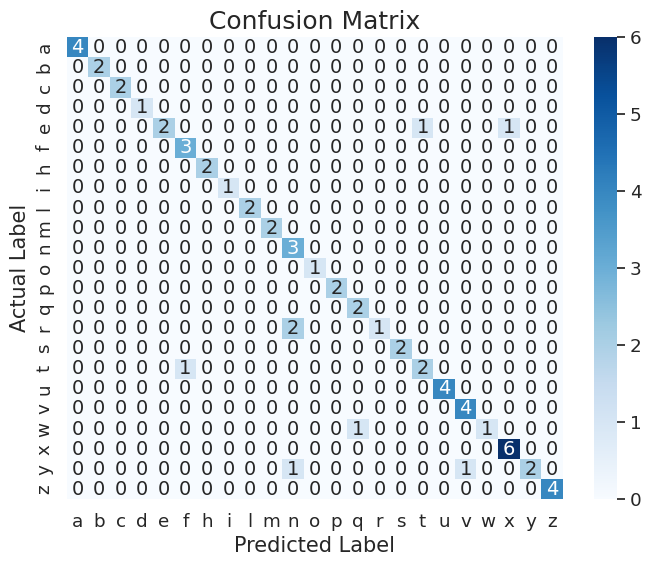

Calculated Accuracy: 87.30%


In [46]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def print_confusion_matrix(y_true, y_pred, class_names):
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Ensure the correct labels by filtering `class_names` with unique classes present in y_true and y_pred
    unique_labels = np.unique(np.concatenate([y_true, y_pred]))
    filtered_class_names = [class_names[i] for i in unique_labels]
    
    # Create a DataFrame for the confusion matrix
    df_cm = pd.DataFrame(cm, index=filtered_class_names, columns=filtered_class_names)
    
    sn.set(font_scale=1.2)  # Label size
    plt.figure(figsize=(8, 6))
    sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 14})  # Font size for annotations
    plt.ylabel("Actual Label", size=15)
    plt.xlabel("Predicted Label", size=15)
    plt.title("Confusion Matrix", size=18)
    plt.show()
    
    # Calculate and print accuracy
    accuracy = (np.trace(cm) / np.sum(cm)) * 100
    print(f"Calculated Accuracy: {accuracy:.2f}%")
# Usage
print_confusion_matrix(y_true, y_pred_classes, class_names=actions)

In [47]:
from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get model predictions for the test set
y_pred_proba = model.predict(X_test)  # Probabilities
y_pred = np.argmax(y_pred_proba, axis=1)  # Predicted class labels
y_true = np.argmax(y_test, axis=1)  # Actual class labels (assuming one-hot encoding)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [48]:
# Calculate F1 score and recall
f1 = f1_score(y_true, y_pred, average='weighted')  # Or 'macro' for unweighted
recall = recall_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1}")
print(f"Recall: {recall}")


F1 Score: 0.8640017830494021
Recall: 0.873015873015873


/home/eric/miniconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/eric/miniconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/home/eric/miniconda3/envs/ML/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


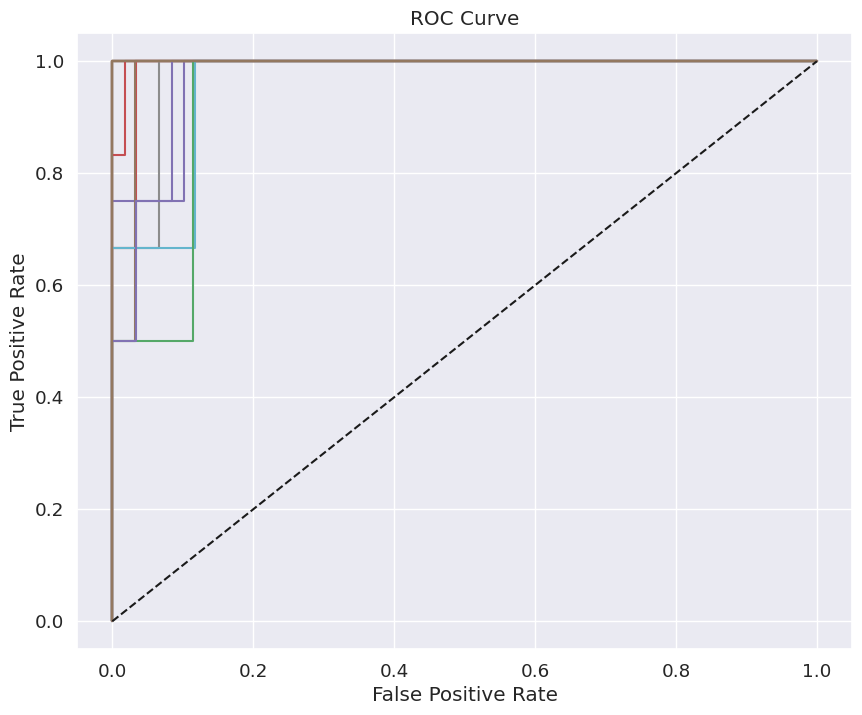

In [49]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# Binarize the labels for multiclass ROC
y_test_bin = label_binarize(y_true, classes=range(actions.shape[0]))

# Plot ROC for each class
plt.figure(figsize=(10, 8))
for i in range(actions.shape[0]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


# 8. Make Predictions

In [50]:
res = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [51]:
actions[np.argmax(res[2])]

'v'

In [52]:
actions[np.argmax(y_test[2])]

'v'

In [53]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [54]:
yhat = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [55]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [56]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[59,  0],
        [ 0,  4]],

       [[61,  0],
        [ 0,  2]],

       [[61,  0],
        [ 0,  2]],

       [[62,  0],
        [ 0,  1]],

       [[59,  0],
        [ 2,  2]],

       [[59,  1],
        [ 0,  3]],

       [[61,  0],
        [ 0,  2]],

       [[62,  0],
        [ 0,  1]],

       [[61,  0],
        [ 0,  2]],

       [[61,  0],
        [ 0,  2]],

       [[57,  3],
        [ 0,  3]],

       [[62,  0],
        [ 0,  1]],

       [[61,  0],
        [ 0,  2]],

       [[60,  1],
        [ 0,  2]],

       [[60,  0],
        [ 2,  1]],

       [[61,  0],
        [ 0,  2]],

       [[59,  1],
        [ 1,  2]],

       [[59,  0],
        [ 0,  4]],

       [[58,  1],
        [ 0,  4]],

       [[61,  0],
        [ 1,  1]],

       [[56,  1],
        [ 0,  6]],

       [[59,  0],
        [ 2,  2]],

       [[59,  0],
        [ 0,  4]]])

In [57]:
accuracy_score(ytrue, yhat)

0.873015873015873